## Vehicle Detection + Advanced Lane Finding

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
* Add Advanced Lane Finding pipeline.
---

In [ ]:
import numpy as np                 # NumPy
import cv2                         # openCV
import glob                        # Filename pattern matching
import matplotlib.pyplot as plt    # 2D plotting
import matplotlib.image as mpimg

# Interactive plotting in separate window
#%matplotlib qt
# Visualizations will be shown in the notebook
%matplotlib inline

## Compute the camera calibration points using chessboard images

In [ ]:
def get_3d2d_points(do_plot=False, do_file=False):
    # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((6*9, 3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
    # Arrays to store object points and image points from all the images
    objpoints = []                     # 3D points in real world space
    imgpoints = []                     # 2D points in image plain
    # List of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    print('Num of calibration images: {0}'.format(len(images)))

    # Step through the list and search for chessboard corners
    for img_id, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        # http://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html#findchessboardcorners
        # cv2.findChessboardCorners(image, patternSize[, corners[, flags]]) → retval, corners
        ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)
        # If found - add object points, add image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            # Draw the plot
            if do_plot:
                plt.imshow(img)
                plt.show()
            # Save to the file
            if do_file:
                write_name = 'corners_' + str(img_id) + '.jpg'
                cv2.imwrite(write_name, img)
    return objpoints, imgpoints

## Distortion correction

In [ ]:
import pickle

def pickle_dump(mtx, dist):
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump(dist_pickle, open('wide_dist_pickle.p', 'wb'))
    
def pickle_load():
    # Getting back the camera calibration result:
    with open('wide_dist_pickle.p', 'rb') as f:
        dist_pickle = pickle.load(f)
        return dist_pickle['mtx'], dist_pickle['dist']
    
def calibrate_camera(img):
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    objpoints, imgpoints = get_3d2d_points(do_plot=False, do_file=False)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    # Save the camera calibration result
    pickle_dump(mtx, dist)
    return mtx, dist

## Color/gradient threshold

Combine color and gradient thresholds to generate a binary image where the lane lines are clearly visible.

Output should be an array of the same size as the input image. The output array elements should be 1 where gradients were in the threshold range, and 0 everywhere else.

In [ ]:
# For universal plotting of results
def plot_row2(img1, img2, label_1, label_2, graysc=True):
    # Plot the result (1 row with 2 images)
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    f.tight_layout()
    if graysc:
        ax1.imshow(img1, cmap='gray')
    else:
        ax1.imshow(img1)
    ax1.set_title(label_1, fontsize=16)
    ax2.imshow(img2, cmap='gray')
    ax2.set_title(label_2, fontsize=16)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
# Apply Sobel (Calculate directional gradient and apply gradient threshold)
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel) 
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Return the magnitude of the gradient for a given sobel kernel 
# size and threshold values in both x and y
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return mask as binary_output image
    return binary_output

# Calculate gradient direction and apply threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Convert to HLS and take S channel
    img_trans = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_trans = img_trans[:,:,2]
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(img_trans, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(img_trans, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use np.arctan2(abs_sobel_y, abs_sobimg_transel_x) to calculate the direction of the gradient
    absgraddir = np.arctan2(abs_sobel_y, abs_sobel_x)
    # Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return this mask as binary_output image
    return binary_output

In [ ]:
def combine_sobel_thresholds(img, do_plot=False):
    # Gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    # Sobel kernel size (choose a larger odd number to smooth gradient measurements)
    ksize = 7
    # Apply Sobel on x-axis
    grad_x_binary = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 255))
    # Apply Sobel on y-axis
    grad_y_binary = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(60, 255))
    # Apply Sobel x and y, compute the magnitude of the gradient and apply a threshold
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 255))
    # Apply Sobel x and y, computes the direction of the gradient and apply a threshold
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.65, 1.05))
    
    # Combine the thresholds
    combined = np.zeros_like(dir_binary)
    combined[((grad_x_binary == 1) & (grad_y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    if do_plot:
        plot_row2(image, grad_x_binary,      'Original Image (Undistorted)', 'Sobel on x-axis')
        plot_row2(grad_y_binary, mag_binary, 'Sobel on y-axis', 'Thresholded Magnitude')
        plot_row2(dir_binary, combined,      'Direction of gradient', 'Combined Thresholds')
    return combined

In [ ]:
def color_channel_threshold(img, thresh=(0, 255), do_plot=False):
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # Extract S channel
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    
    if do_plot:
        plot_row2(image, s_binary, 'Original Image (Undistorted)', 'HLS(S-channel) threshold')
    return s_binary

## Perspective transform

Pick four points in a trapezoidal shape (similar to region masking) that would represent a rectangle when looking down on the road from above.

The easiest way to do this is to investigate an image where the lane lines are straight, and find four points lying along the lines that, after perspective transform, make the lines look straight and vertical from a bird's eye view perspective.

In [ ]:
# Applies an image mask
# Only keeps the region of the image defined by the polygon formed from `vertices`.
# The rest of the image is set to black.
def region_of_interest(img, vertices):
    # Defining a blank mask to start with
    mask = np.zeros_like(img)
    ignore_mask_color = 255
    # Fill pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Return the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def perspective_transform(img, inv=False):
    # Define 4 source points
    src = np.float32([[180, img.shape[0]], [575, 460], 
                      [705, 460], [1150, img.shape[0]]])
    # Define 4 destination points
    dst = np.float32([[320, img.shape[0]], [320, 0], 
                      [960, 0], [960, img.shape[0]]])
    # Use cv2.getPerspectiveTransform() to get M, the transform matrix
    if inv == False:
        M = cv2.getPerspectiveTransform(src, dst)
    else:
        M = cv2.getPerspectiveTransform(dst, src)
    # Use cv2.warpPerspective() to warp image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

## Image Pipeline

In [ ]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # Was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = collections.deque(12*[0.0, 0.0, 0.0], 12)
        # Average x values of the fitted line over the last n iterations
        self.bestx = None
        # Polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        # Polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # Radius of curvature of the line in some units (meters)
        self.radius_of_curvature = None 
        # Distance in meters of vehicle center from the line
        self.line_base_pos = None
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None

In [ ]:
# CAMERA CALIBRATION AND IMAGE UNDISTORTION
def get_undist():
    # Test undistortion on the image
    img = cv2.imread('camera_cal/calibration1.jpg')
    #img = mpimg.imread('test_images/test1.jpg')
    # Calibrate camera and save data to pickle
    #mtx, dist = calibrate_camera(img)
    # Load calibration data from pickle
    mtx, dist = pickle_load()
    # Undistort image
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return mtx, dist

In [ ]:
# COLOR / GRADIENT THRESHOLD
mtx, dist = get_undist()
def threshold(image):
    # Get calibration data
    #mtx, dist = get_undist()
    # Undistort image
    undist_image = cv2.undistort(image, mtx, dist, None, mtx)
    # Perform Sobel operations and combine thresholds
    combine_sobel = combine_sobel_thresholds(undist_image, do_plot=False)
    # Threshold color channel
    color_thresh = color_channel_threshold(undist_image, thresh=(160, 255), do_plot=False)
    # Combine color and gradient thresholds
    combined_binary = np.zeros_like(color_thresh)
    combined_binary[(combine_sobel == 1) | (color_thresh == 1)] = 1
    return combined_binary, undist_image

In [ ]:
# PERSPECTIVE TRANSFORM
def warp(thresholded):
    warped_img = perspective_transform(thresholded)
    # Define image mask (polygon of interest)
    imshape = warped_img.shape
    vertices = np.array([[(200, imshape[0]), (200, 0), (imshape[1] - 200, 0), 
                      (imshape[1]-200, imshape[0])]], dtype=np.int32)
    masked_img = region_of_interest(warped_img, vertices)
    return masked_img

In [ ]:
import collections

def find_base_pts(warped):
    # Take a histogram of the bottom half of the masked image
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

# DETECT LANE LINES
def detect_lines(warped):
    lines_detected = False
    
    # Find the starting point for the left and right lines
    midpoint, leftx_base, rightx_base = find_base_pts(warped)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255

    # Number of sliding windows
    nwindows = 9
    # Height of windows: e.g. 720/9=80
    window_height = np.int(warped.shape[0] / nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Sliding windows
    if (left_line.detected == False) or (right_line.detected == False) :
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = warped.shape[0] - (window + 1) * window_height
            win_y_high = warped.shape[0] - window * window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        left_line.detected = True
        right_line.detected = True
    else:
        left_lane_inds = ((nonzerox > (left_line.current_fit[0] * (nonzeroy**2) + 
                                       left_line.current_fit[1] * nonzeroy + 
                                       left_line.current_fit[2] - margin)) & 
                          (nonzerox < (left_line.current_fit[0] * (nonzeroy**2) + 
                                       left_line.current_fit[1] * nonzeroy + 
                                       left_line.current_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (right_line.current_fit[0] * (nonzeroy**2) + 
                                        right_line.current_fit[1] * nonzeroy + 
                                        right_line.current_fit[2] - margin)) & 
                           (nonzerox < (right_line.current_fit[0] * (nonzeroy**2) + 
                                        right_line.current_fit[1] * nonzeroy + 
                                        right_line.current_fit[2] + margin)))
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Here we need to save successful fit of lines to prevent case with empty x, y
    if (len(leftx) < 1500):
        leftx = left_line.allx
        lefty = left_line.ally
        left_line.detected = False
    else:
        left_line.allx = leftx
        left_line.ally = lefty
    if (len(rightx) < 1500):
        rightx = right_line.allx
        righty = right_line.ally
        right_line.detected = False
    else:
        right_line.allx = rightx
        right_line.ally = righty
    
    # Fit a second order polynomial to each
    right_fit = np.polyfit(righty, rightx, 2)
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Sanity check.
    # Initial iteration
    if (left_line.current_fit[0] == False):
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit
    
    if (abs(left_line.current_fit[1] - left_fit[1]) > 0.18):
        left_line.current_fit = left_line.best_fit
        left_line.detected = False
    else:
        left_line.current_fit = left_fit
        left_line.recent_xfitted.pop()
        left_line.recent_xfitted.appendleft(left_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_line.recent_xfitted:
            avg = avg + element
        left_line.best_fit = avg / (len(left_line.recent_xfitted))
        
    if (abs(right_line.current_fit[1] - right_fit[1]) > 0.18):
        right_line.current_fit = right_line.best_fit
        right_line.detected = False
    else:
        right_line.current_fit = right_fit
        right_line.recent_xfitted.pop()
        right_line.recent_xfitted.appendleft(right_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_line.recent_xfitted:
            avg = avg + element
        right_line.best_fit = avg / (len(right_line.recent_xfitted))
        
    if (abs(right_line.current_fit[1] - right_fit[1]) > 0.38 and
        abs(left_line.current_fit[1] - left_fit[1]) < 0.1):
        right_line.current_fit[0] = left_line.current_fit[0]
        right_line.current_fit[1] = left_line.current_fit[1]
        right_line.current_fit[2] = left_line.current_fit[2] + 600
        right_line.recent_xfitted.pop()
        right_line.recent_xfitted.appendleft(right_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in right_line.recent_xfitted:
            avg = avg + element
        right_line.best_fit = avg / (len(right_line.recent_xfitted))
        
    if (abs(left_line.current_fit[1] - left_fit[1]) > 0.38 and
        abs(right_line.current_fit[1] - right_fit[1]) < 0.1):
        left_line.current_fit = left_fit
        left_line.recent_xfitted.pop()
        left_line.recent_xfitted.appendleft(left_line.current_fit)
        avg = np.array([0,0,0], dtype='float')
        for element in left_line.recent_xfitted:
            avg = avg + element
        left_line.best_fit = avg / (len(left_line.recent_xfitted))
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0] - 1, warped.shape[0] )
    left_fitx = (left_line.current_fit[0] * ploty**2 + 
                 left_line.current_fit[1] * ploty + 
                 left_line.current_fit[2])
    right_fitx = (right_line.current_fit[0] * ploty**2 + 
                  right_line.current_fit[1] * ploty + 
                  right_line.current_fit[2])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx

In [ ]:
# VEHICLE OFFSET FROM LANE CENTER
def calc_offset(xm_per_pix, ym_per_pix, y_eval, left_fit_cr, right_fit_cr):
    # Calculate x bottom position for y for left lane
    left_lane_bottom = (left_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                        left_fit_cr[1] * (y_eval * ym_per_pix) + left_fit_cr[2])
    # Calculate x bottom position for y for right lane
    right_lane_bottom = (right_fit_cr[0] * (y_eval * ym_per_pix) ** 2 + 
                         right_fit_cr[1] * (y_eval * ym_per_pix) + right_fit_cr[2])
    # Calculate the mid point of the lane
    lane_midpoint = float(right_lane_bottom + left_lane_bottom) / 2
    # Calculate the image center in meters from left edge of the image
    image_mid_point_in_meter = 1280/2 * xm_per_pix
    # Positive value indicates vehicle on the right side of lane center, else on the left.
    lane_deviation = (image_mid_point_in_meter - lane_midpoint)
    return lane_deviation

# MEASURE RADIUS OF CURVATURE AND VEHICLE OFFSET
def rad_and_offset(ploty, leftx, lefty, rightx, righty, left_fit, right_fit):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = (((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2)**1.5) / 
                     np.absolute(2 * left_fit[0]))
    right_curverad = (((1 + (2 * right_fit[0] * y_eval + right_fit[1])**2)**1.5) / 
                      np.absolute(2 * right_fit[0]))
    curverad_avg = (left_curverad + right_curverad)/2

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720   # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    # Fit a second order polynomial to each
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)

    # Calculate the new radius of curvature in meters
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + 
                           left_fit_cr[1])**2)**1.5) / np.absolute(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + 
                            right_fit_cr[1])**2)**1.5) / np.absolute(2 * right_fit_cr[0])
    curverad_avg = (left_curverad + right_curverad) / 2
    # Vehicle offset
    lane_deviation = calc_offset(xm_per_pix, ym_per_pix, y_eval, left_fit_cr, right_fit_cr)
    
    return left_curverad, right_curverad, lane_deviation

In [ ]:
# DRAWING
def draw_res(warped, undistorted, out_img, ploty, left_fitx, 
             right_fitx, left_curverad, right_curverad, lane_deviation):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warped, warped, warped))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = perspective_transform(color_warp, inv=True)
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)

    x_offset = result.shape[1] - 320 - 30
    y_offset = 30
    thumb = cv2.resize(out_img, (320, 200), interpolation = cv2.INTER_CUBIC)
    result[y_offset:y_offset + thumb.shape[0], x_offset:x_offset + thumb.shape[1]] = thumb

    font = cv2.FONT_HERSHEY_SIMPLEX
    curv_l_label = 'Left line Curvature: {:.0f} m.'.format(left_curverad)
    curv_r_label = 'Right line Curvature: {:.0f} m.'.format(right_curverad)
    deviation_label = 'Vehicle Deviation: {:.3f} m.'.format(lane_deviation)

    cv2.putText(result, curv_l_label, (30, 60), font, 1, (255,255,255), 2)
    cv2.putText(result, curv_r_label, (30, 110), font, 1, (255,255,255), 2)
    cv2.putText(result, deviation_label, (30, 160), font, 1, (255,255,255), 2)

    plot_row2(undistorted, result, 'Original Frame (Undistorted)', 'Processed Frame')
    fig = plt.figure(figsize=(20, 8))
    plt.imshow(result)
    return result

## Vehicle Detection Pipeline

### Helpers

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

    
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=3):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
%matplotlib inline

In [3]:
# CLASSIFIER TRAINING PIPELINE

print('Loading dataset...')

# Read in cars and notcars
cars = glob.glob('dataset/non-vehicles/**/*.png', recursive=True)
notcars = glob.glob('dataset/vehicles/**/*.png', recursive=True)
# Stat
print('NOTCARS: {}'.format(len(cars)))
print('CARS: {}'.format(len(notcars)))


### TODO: Tweak these parameters and see how the results change.
color_space    = 'YCrCb'    # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient         = 9          # HOG orientations
pix_per_cell   = 8          # HOG pixels per cell
cell_per_block = 2          # HOG cells per block
hog_channel    = 'ALL'      # Can be 0, 1, 2, or "ALL"
spatial_size   = (32, 32)   # Spatial binning dimensions
hist_bins      = 32         # Number of histogram bins
spatial_feat   = True       # Spatial features on or off
hist_feat      = True       # Histogram features on or off
hog_feat       = True       # HOG features on or off

car_features = extract_features(cars, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
print('car_features: DONE')
notcar_features = extract_features(notcars, color_space=color_space, 
                                   spatial_size=spatial_size, hist_bins=hist_bins, 
                                   orient=orient, pix_per_cell=pix_per_cell, 
                                   cell_per_block=cell_per_block, 
                                   hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                   hist_feat=hist_feat, hog_feat=hog_feat)
print('notcar_features: DONE')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)


print('Using:',orient,'orientations',pix_per_cell, 
      'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

# Save data to pickle file
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
pickle.dump(dist_pickle, open("svc_pickle.p", 'wb') )

print('Classifier parameters were saved to file')


Loading dataset...
NOTCARS: 8968
CARS: 8792
car_features: DONE
notcar_features: DONE
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
56.39 Seconds to train SVC...
Test Accuracy of SVC =  0.9913
Classifier parameters were saved to file


Load Classifier parameters...
Load is done
Feature vector length: 8460
9
8
2
(32, 32)
32


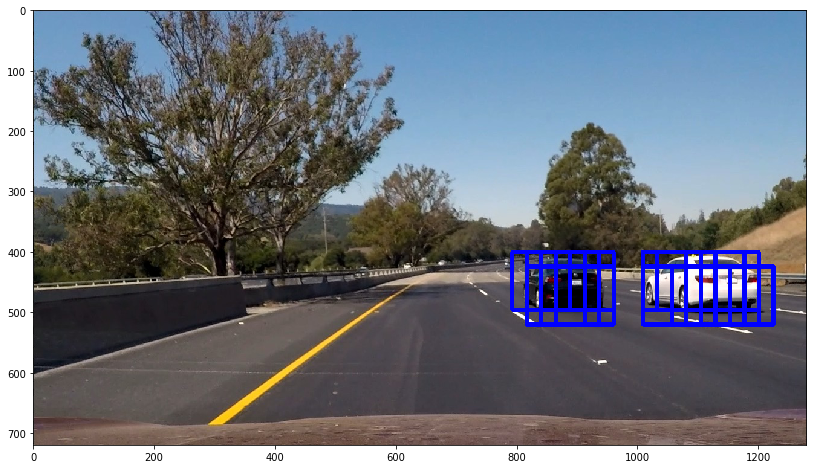

In [10]:
print('Load Classifier parameters...')
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

print('Load is done')
print('Feature vector length:', len(X_train[0]))

print(orient)
print(pix_per_cell)
print(cell_per_block)
print(spatial_size)
print(hist_bins)

img = mpimg.imread('test_images/test6.jpg')
#draw_image = np.copy(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
#img = img.astype(np.float32)/255

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, :, :]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = ((ch1.shape[1] // pix_per_cell) - cell_per_block + 1)
    nyblocks = ((ch1.shape[0] // pix_per_cell) - cell_per_block + 1)
    nfeat_per_block = orient * cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window =8*8
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos + nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 0:
                xbox_left = np.int(xleft * scale)
                ytop_draw = np.int(ytop * scale)
                win_draw = np.int(window * scale)
                cv2.rectangle(draw_img, (xbox_left, ytop_draw + ystart), 
                              (xbox_left + win_draw, ytop_draw + win_draw + ystart), (0,0,255), 6) 
    return draw_img
    
ystart = 400
ystop = 656
scale = 1.5
    
out_img = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, 
                    pix_per_cell, cell_per_block, spatial_size, hist_bins)

fig = plt.figure(figsize=(20, 8))
plt.imshow(out_img)

In [ ]:
def image_pipeline(image):
    # Threshold image
    thresholded, undistorted = threshold(image)
    # Warp image
    warped = warp(thresholded)
    # Detect lane lines
    out_img, ploty, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx = detect_lines(warped)
    # Radius of curvature for left and right lines
    left_curverad, right_curverad, lane_deviation = rad_and_offset(ploty, leftx, lefty, rightx, 
                                                                   righty, left_fit, right_fit)
    # Draw output
    proc_img = draw_res(warped, undistorted, out_img, ploty, left_fitx, right_fitx, 
                        left_curverad, right_curverad, lane_deviation)
    return proc_img

In [ ]:
# MONITOR (FOR TESTING IMAGE PIPELINE)
# Load original image from camera
left_line = Line()
right_line = Line()
image = mpimg.imread('test_images/test1.jpg')
proc_img = image_pipeline(image)

In [ ]:
# MONITOR (FOR TESTING VIDEO PIPELINE)
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
left_line = Line()
right_line = Line()
output_video = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(image_pipeline)
%time video_clip.write_videofile(output_video, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_video))